# Initial EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text

from utils import setup_import

setup_import()

from fraud_detection.data.database import get_db_engine

plt.style.use("ggplot")
sns.set_palette("Set2")

%matplotlib inline

%load_ext autoreload
%autoreload 2

ROOT: /workspace/fraud-ml-pipeline


In [2]:
print("Connecting to DB...")
engine = get_db_engine()

query = text("""
             SELECT * FROM transactions ORDER BY trans_date LIMIT 1000000
             """)

df = pd.read_sql_query(sql=query, con=engine)

df["trans_date_trans_time"] = pd.to_datetime(df["trans_date"] + " " + df["trans_time"])

df["dod"] = pd.to_datetime(df["dob"])

df["is_fraud"] = df["is_fraud"].astype(int)
df = df.drop(["trans_date", "trans_time"], axis=1)

print(f"{df.shape=}")
df.info()
df.head()

Connecting to DB...
df.shape=(1000000, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   ssn                    1000000 non-null  object        
 1   cc_num                 1000000 non-null  int64         
 2   first                  1000000 non-null  object        
 3   last                   1000000 non-null  object        
 4   gender                 1000000 non-null  object        
 5   street                 1000000 non-null  object        
 6   city                   1000000 non-null  object        
 7   state                  1000000 non-null  object        
 8   zip                    1000000 non-null  int64         
 9   lat                    1000000 non-null  float64       
 10  long                   1000000 non-null  float64       
 11  city_pop               1000000 non-null  int64 

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_date_trans_time,dod
0,745-09-1426,6585487099861626,Brittany,Matthews,F,91485 Baker Shoal,Tony,WI,54563,45.4741,...,9970c2d002015be6384bc3eef3f8af6d,1704073640,gas_transport,92.91,0,"fraud_Reilly, Heaney and Cole",45.342331,-91.919985,2024-01-01 10:47:20,1998-07-29
1,015-42-8701,4033542168940,Carol,Colon,F,7898 Hamilton Spur Apt. 575,Champlain,VA,22438,38.0214,...,a2e1333feb3142acc6279ce505621028,1704074136,gas_transport,108.12,0,fraud_Ledner-Pfannerstill,37.567759,-77.694131,2024-01-01 10:55:36,1986-07-06
2,400-40-3758,4722820055775,Vanessa,Fernandez,F,728 Brittany Motorway Suite 884,Harpersville,AL,35078,33.3234,...,478e409841efd1a2f1765cd9ce8a4e74,1704065682,gas_transport,97.70,0,"fraud_Lind, Huel and McClure",34.185202,-86.506550,2024-01-01 08:34:42,1994-10-03
3,400-40-3758,4722820055775,Vanessa,Fernandez,F,728 Brittany Motorway Suite 884,Harpersville,AL,35078,33.3234,...,c414c97a47fe849d2d8497274cff33a7,1704045780,gas_transport,78.99,0,fraud_Schmitt Inc,32.507215,-87.418474,2024-01-01 03:03:00,1994-10-03
4,162-48-5106,3599102290147672,Lisa,Perry,F,156 Justin Springs,West Valley,NY,14171,42.4315,...,d6e8a023d90501254999840907eb46fd,1704054617,gas_transport,60.55,0,fraud_Berge LLC,41.446588,-79.023898,2024-01-01 05:30:17,1981-07-27


## 1. Descritive Statistics

### Place vs. Amount

In [3]:
display(df[['amt', 'lat', 'long', 'merch_lat', 'merch_long']].describe())

,amt,lat,long,merch_lat,merch_long
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,84.766227,37.477950,-92.067754,37.478895,-92.068840
std,120.569090,5.187179,16.414189,5.219149,16.423985
min,1.000000,19.589300,-164.436100,18.606801,-165.409986
25%,33.547500,33.905600,-98.668800,33.874888,-99.009774
50%,61.590000,38.250700,-87.554800,38.181899,-87.299915
75%,88.970000,41.076800,-80.047400,41.187166,-79.778319
max,17635.230000,64.910900,-67.472200,65.907181,-66.490662


### Distribution of Fraud

In [4]:
df["is_fraud"].value_counts(normalize=True) * 100

is_fraud
0    98.619
1     1.381
Name: proportion, dtype: float64

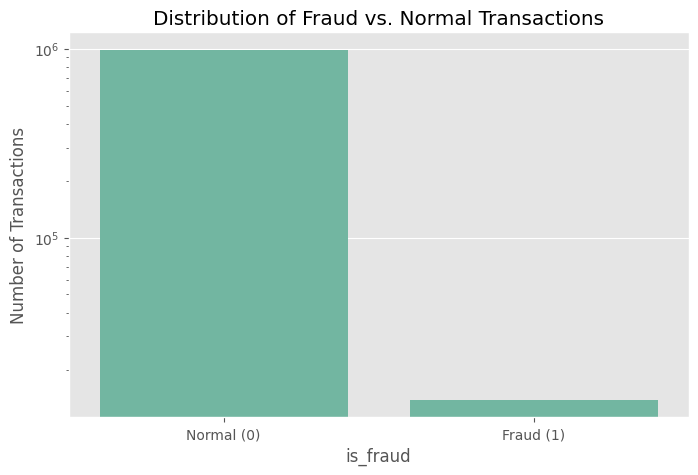

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraud vs. Normal Transactions')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

### Fraud vs. Amount

In [6]:
df.groupby('is_fraud')['amt'].describe()


,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,986190.0,78.509507,98.744424,1.00,33.430,61.270,87.6600,17635.23
1,13810.0,531.566752,392.336178,1.47,244.055,395.075,909.5275,1373.64


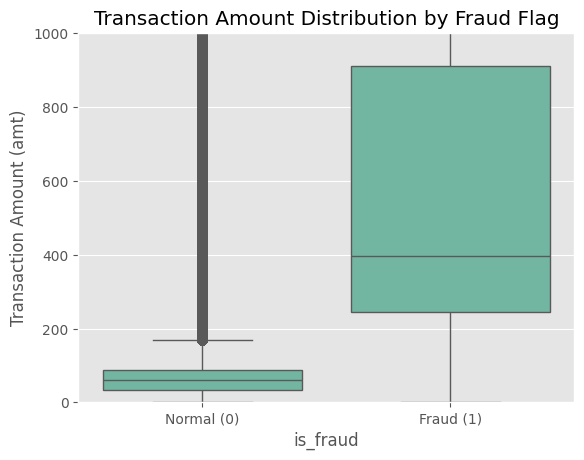

In [7]:
# 取引金額は外れ値が多い可能性があるため、y軸の上限を絞って見やすくする
sns.boxplot(x='is_fraud', y='amt', data=df)
plt.title('Transaction Amount Distribution by Fraud Flag')
plt.ylim(0, 1000) # y軸の表示範囲を0から400に限定。適宜調整してください。
plt.ylabel('Transaction Amount (amt)')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

<Figure size 1000x600 with 0 Axes>

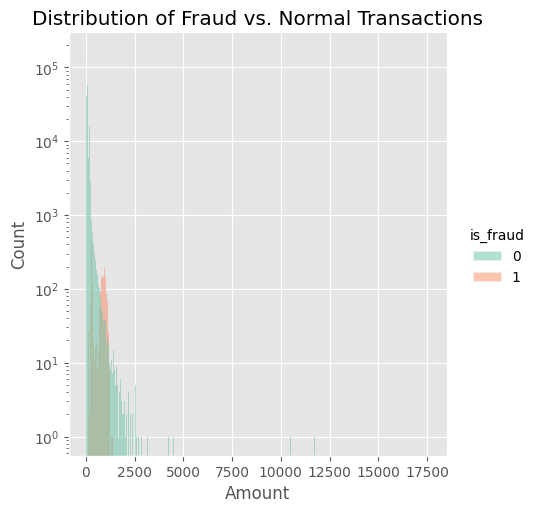

In [8]:
plt.figure(figsize=(10, 6))
sns.displot(data=df, x="amt", hue="is_fraud")
plt.title('Distribution of Fraud vs. Normal Transactions')
plt.xlabel('Amount')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

### 分析結果の要約
#### データの不均衡性
データは「相当不均衡」。不正利用は全体のわずか1.38%しか存在しない。
モデルの評価方法（例：単純な正解率(Accuracy)だけでは不十分）や学習手法（例：サンプリング）を工夫する必要あり。

#### 取引金額(amt)の分布
不正の方は幅のある分布で、正常な取引は比較的少額に集中

**正常な取引** (is_fraud=0):<br>
箱ひげ図で箱が非常に低い位置に圧縮されている。取引額の中央値（50%点）が約$61と、少額決済に集中。一方で、max値が$17,635にも達しており、図の長い上ヒゲが示すように、多数の外れ値（高額決済）が存在する。
<br>
**不正利用** (is_fraud=1):<br>
対照的に、不正利用は25%点が約244、75909と、正常な取引に比べて明らかに高額で、かつ金額のばらつき（分布の幅）も大きいことがわかります。

### 考察から得られる仮説
- 仮説1: amt（取引金額）は、不正利用を検知する上で非常に重要
- 仮説2: モデルを学習させる際に、この極端な不均衡データの扱いに注意が必要。

## 2. Categprical Data and Fraud

### Fraud Rate by Transaction Category


In [9]:
fraud_rate_by_category = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False) * 100
fraud_rate_by_category

category
entertainment     100.000000
food_dining       100.000000
health_fitness    100.000000
shopping_net      100.000000
kids_pets         100.000000
home              100.000000
shopping_pos      100.000000
travel            100.000000
personal_care     100.000000
misc_pos           99.372385
misc_net            3.003783
grocery_pos         0.857904
gas_transport       0.295663
grocery_net         0.130090
Name: is_fraud, dtype: float64

In [10]:
fraud_count_by_category = df.groupby('category')['is_fraud'].count().sort_values(ascending=False)
fraud_count_by_category


category
gas_transport     377119
grocery_pos       371953
grocery_net       186025
misc_net           57361
shopping_net        3135
shopping_pos        1694
misc_pos             478
entertainment        408
personal_care        369
home                 349
food_dining          339
kids_pets            314
health_fitness       242
travel               214
Name: is_fraud, dtype: int64

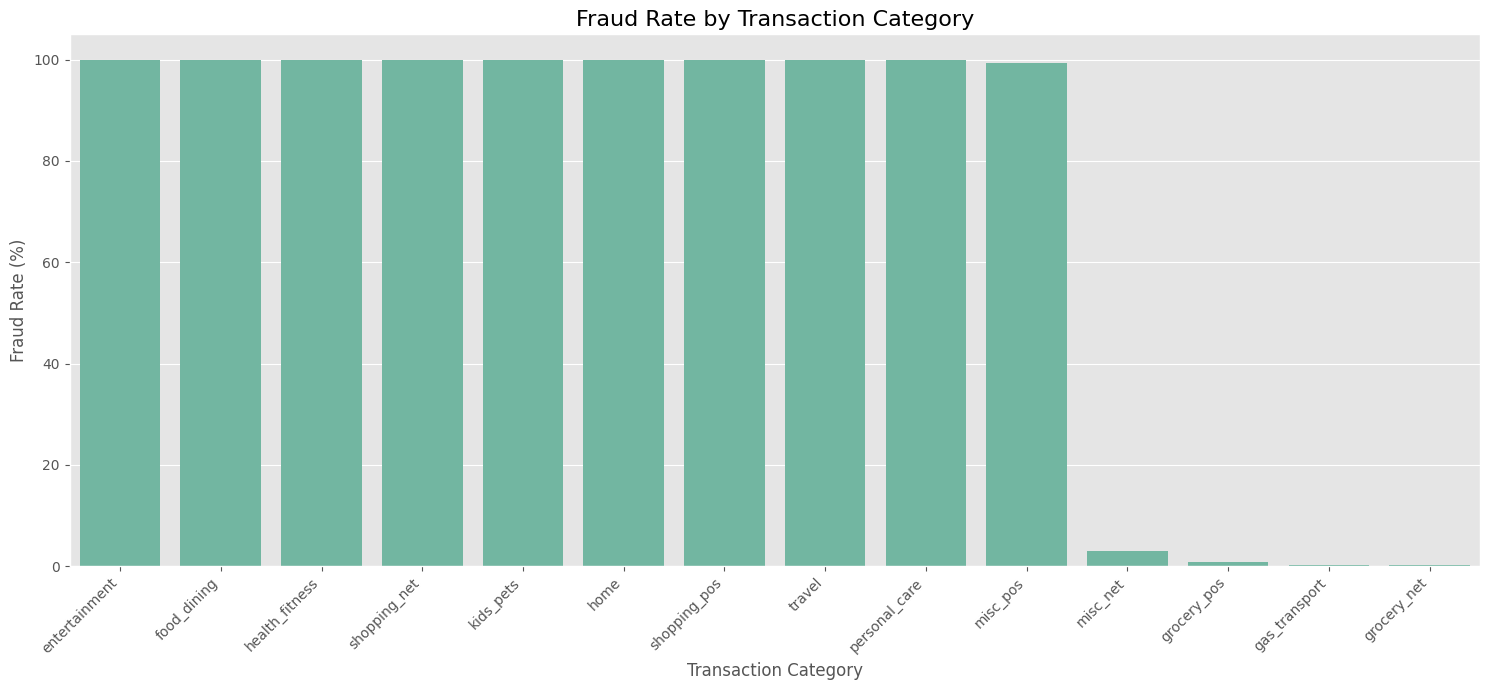

In [11]:
plt.figure(figsize=(15, 7))
sns.barplot(x=fraud_rate_by_category.index, y=fraud_rate_by_category.values)
plt.title('Fraud Rate by Transaction Category', fontsize=16)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xlabel('Transaction Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Overall Transaction Count by Category


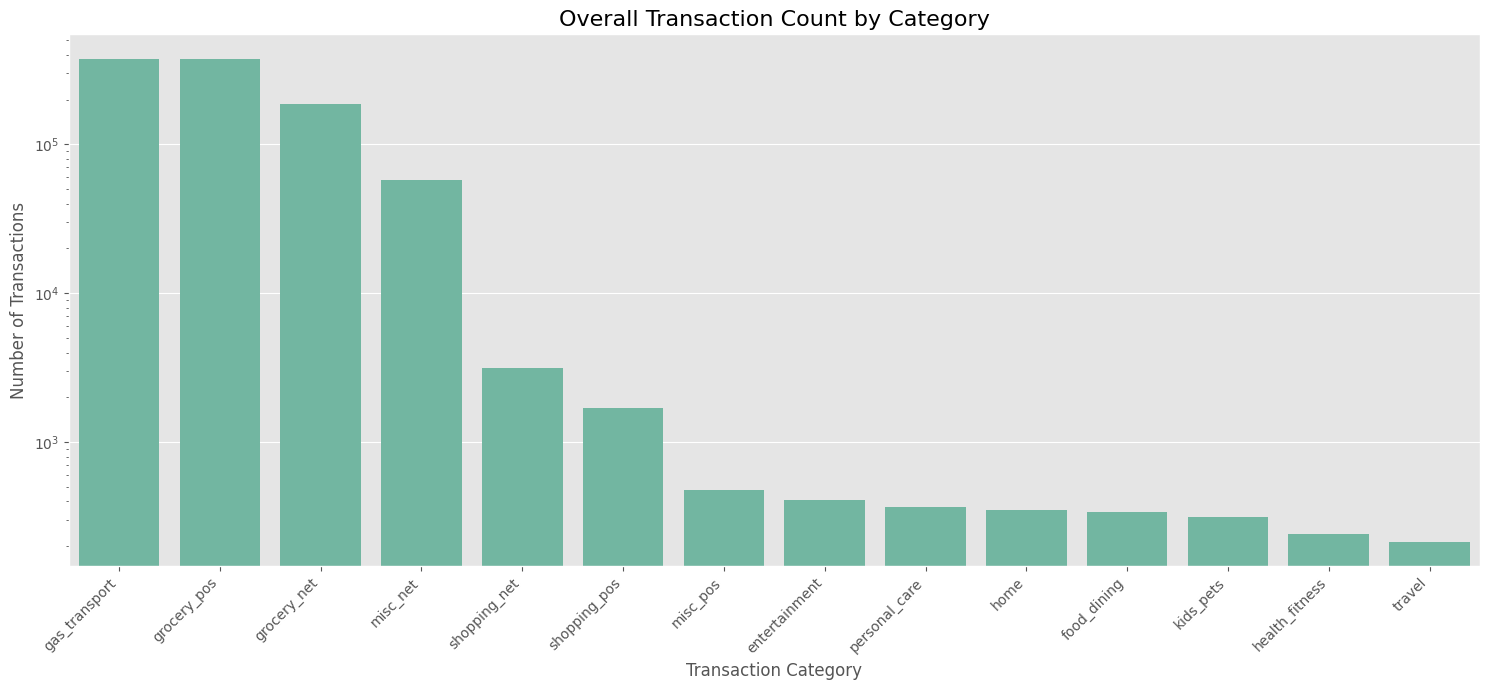

In [12]:
plt.figure(figsize=(15, 7))
sns.countplot(x='category', data=df, order=df['category'].value_counts().index)
plt.title('Overall Transaction Count by Category', fontsize=16)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Transaction Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [13]:
ct = pd.crosstab(df['category'], df['is_fraud'])
ct


is_fraud,0,1
category,,
entertainment,0,408
food_dining,0,339
gas_transport,376004,1115
grocery_net,185783,242
grocery_pos,368762,3191
health_fitness,0,242
home,0,349
kids_pets,0,314
misc_net,55638,1723


※内部のロジックにより、不均衡が生じている

### ここまでのまとめ
金額、カテゴリと不正利用の関係について、非常に深い洞察が得られた。これにより、後工程の特徴量エンジニアリングで有効となりそうな、以下のようなアイデアの種が見えてきた。

- amt（取引金額）そのもの
- categoryを何らかの形で数値化したもの（One-Hotエンコーディング？）
- categoryごとの統計量から算出したリスクスコア

## 3. Extracting Time-based Features

In [ ]:
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()

### 時間帯ごとの分析

In [28]:
hourly_fraud_rate = df.groupby('hour')['is_fraud'].mean().sort_index() * 100
hourly_trans_count = df.groupby('hour')['is_fraud'].count().sort_index()
hourly_fraud_rate

hour
0      1.524898
1      1.547438
2      1.570317
3      1.551845
4      0.128248
5      0.124705
6      0.102360
7      0.132357
8      0.125286
9      0.124553
10     0.118165
11     0.122811
12    10.906298
13    10.931486
14    10.984848
15    10.231815
16    10.558069
17    10.954848
18    10.688259
19    11.145273
20    10.455975
21    10.210444
22    73.837342
23    74.504950
Name: is_fraud, dtype: float64

In [27]:
hourly_trans_count

hour
0     82235
1     82265
2     82149
3     82418
4     81093
5     80991
6     81086
7     80842
8     81414
9     81090
10    81242
11    81426
12     1302
13     1299
14     1320
15     1251
16     1326
17     1351
18     1235
19     1301
20     1272
21     1283
22     4365
23     4444
Name: ssn, dtype: int64

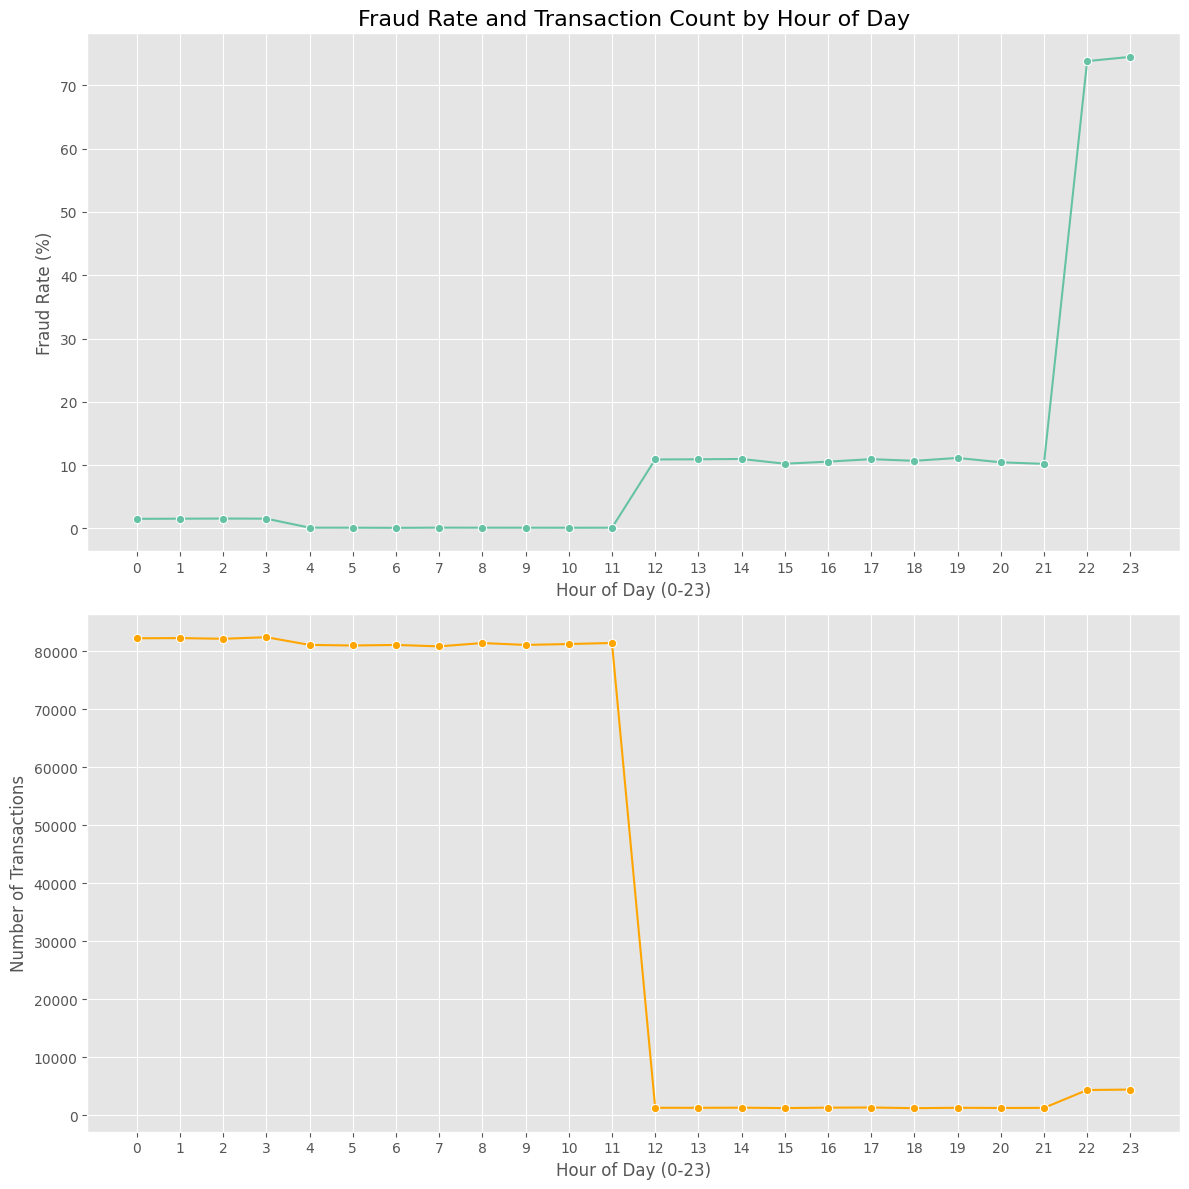

In [39]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
sns.lineplot(x=hourly_fraud_rate.index, y=hourly_fraud_rate.values, marker='o')
plt.title('Fraud Rate and Transaction Count by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.xticks(range(0, 24))

plt.subplot(2, 1, 2)
sns.lineplot(x=hourly_trans_count.index, y=hourly_trans_count.values, marker='o', color='orange')
plt.xlabel('Hour of Day (0-23)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(range(0, 24))

plt.tight_layout()
plt.show()

### 曜日ごとの分析

In [43]:
dow_fraud_rate = df.groupby('day_of_week')['is_fraud'].mean() * 100
dow_fraud_rate

day_of_week
Friday       1.211926
Monday       1.577191
Saturday     1.003736
Sunday       1.222123
Thursday     1.431704
Tuesday      1.932524
Wednesday    1.806953
Name: is_fraud, dtype: float64

In [44]:
dow_trans_count = df.groupby('day_of_week')['is_fraud'].count()
dow_trans_count

day_of_week
Friday       167997
Monday        94979
Saturday     201846
Sunday       191961
Thursday     115387
Tuesday      107683
Wednesday    120147
Name: is_fraud, dtype: int64

In [45]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_fraud_rate = dow_fraud_rate.reindex(day_order)

dow_fraud_rate

day_of_week
Monday       1.577191
Tuesday      1.932524
Wednesday    1.806953
Thursday     1.431704
Friday       1.211926
Saturday     1.003736
Sunday       1.222123
Name: is_fraud, dtype: float64

In [46]:
dow_trans_count = dow_trans_count.reindex(day_order)
dow_trans_count

day_of_week
Monday        94979
Tuesday      107683
Wednesday    120147
Thursday     115387
Friday       167997
Saturday     201846
Sunday       191961
Name: is_fraud, dtype: int64

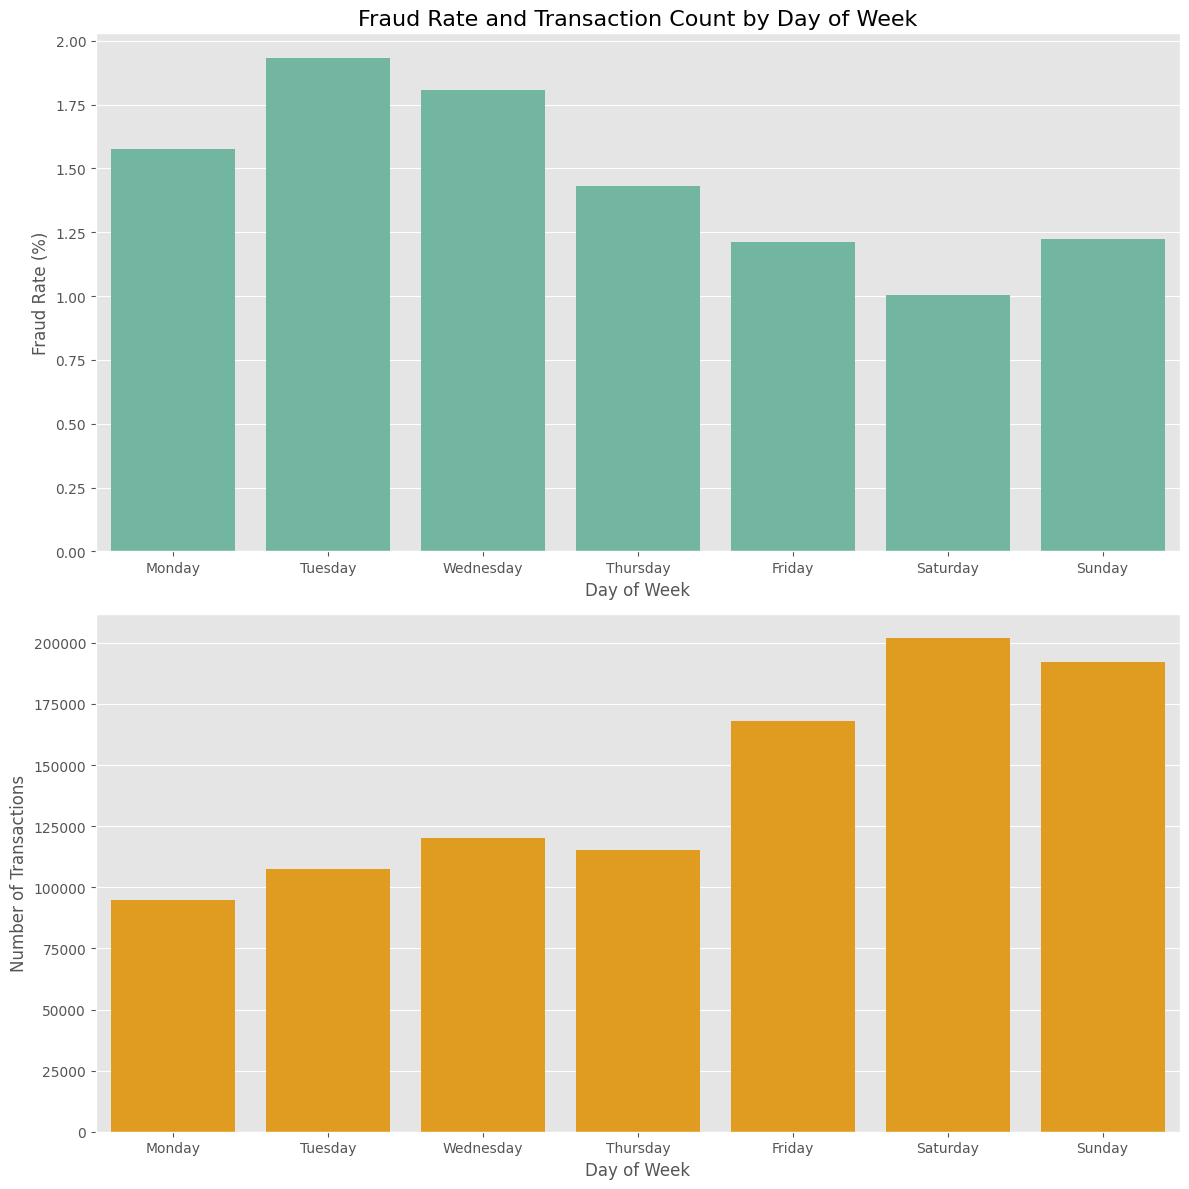

: 

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sns.barplot(x=dow_fraud_rate.index, y=dow_fraud_rate.values)
plt.title('Fraud Rate and Transaction Count by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)

plt.subplot(2, 1, 2)
sns.barplot(x=dow_trans_count.index, y=dow_trans_count.values, color='orange')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

plt.tight_layout()
plt.show()